This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

## BOLFIRE


[Likelihood-free inference by ratio estimation](https://doi.org/10.1214/20-BA1238) (LFIRE) [1] is based on the idea that we can calculate approximate posterior densities based on the observed data and a probabilistic classifier trained with simulated data. [BOLFIRE](http://urn.fi/URN:NBN:fi:hulib-201908283357) [2] combines this approach with Bayesian optimisation and learns an approximate posterior model that can be used to sample the approximate posterior distribution. This tutorial demonstrates how to use BOLFIRE in ELFI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import GPy
import elfi

In [2]:
seed = 100123

### Example

This tutorial uses BOLFIRE to estimate the posterior distribution over two model parameters in a lag-one autoregressive model with conditional heteroskedasticity (ARCH(1)) when the prior distribution over parameter values is U(-1, 1) x U(0, 1). For more details, see [1, Section 5.2][2, Section 5.2]. 

We load this example from ELFI examples and simulate observed data with parameter values 0.3 and 0.7.

In [3]:
from elfi.examples import arch
m = arch.get_model(true_params=[0.3, 0.7], seed_obs=seed)

The observed data is a time series with 100 observations.

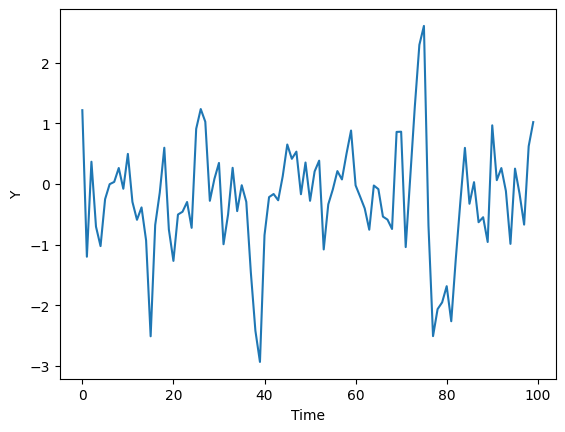

In [4]:
plt.plot(np.squeeze(m.observed['Y']))
plt.xlabel('Time')
plt.ylabel('Y');

The observed and simulated time series are compressed into 17 summary statistics that include the time series mean, variance, autocorrelations, and pairwise combinations between autocorrelations.

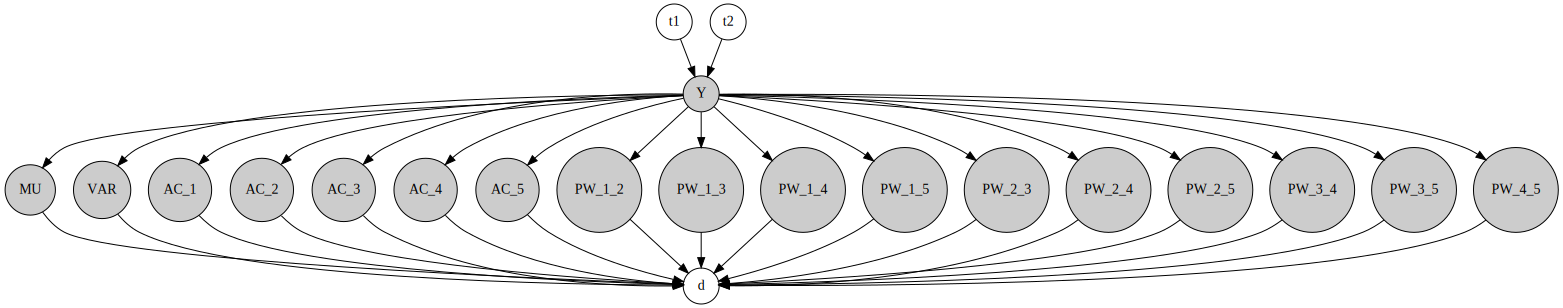

In [5]:
elfi.draw(m)

### Log-ratio estimation

BOLFIRE uses a probabilistic classifier to estimate the log-ratio between probabilities $p_1$ and $p_0$ where $p_1$ is the probability that the simulator would produce the observed data with selected parameter values and $p_0$ is the probability that the simulator would produce the observed data with parameter values sampled from the prior distribution.

The ratio estimation classifiers available in ELFI include `LogisticRegression` that uses [logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) with lasso regularisation and `GPClassifier` that uses [Gaussian process classification](https://github.com/SheffieldML/notebook/blob/master/GPy/basic_classification.ipynb). Here we use lasso logistic regression. The parameter `class_min` is used to ensure that log-ratio estimates are finite.

In [6]:
classifier = elfi.methods.classifier.LogisticRegression(class_min=0.001)

In addition to the classifier, we need to choose features and simulation count, or how the observed and simulated data are represented and how many simulations are used to construct the feature sets used to train the classifier.

The features must be included as observable nodes in the ELFI model. These include the simulator and summary statistics nodes. Here we use all summary statistics as features.

In [7]:
feas = [node for node in m.nodes if isinstance(m[node], elfi.model.elfi_model.Summary)]

A suitable simulation count depends on the parameter estimation task as well as the selected classification method and feature representation. Simulation counts between 100 and 1000 have been used in previous works [1][2].

In [8]:
nsim = 500

For demonstration purpose, let us estimate the log-ratio at `params`. We run `nsim` simulations with parameters sampled from the prior distribution and `nsim` simulations with the selected candidate parameters.

In [9]:
from elfi.methods.utils import batch_to_arr2d
nsim = 500
params = {'t1': 0.2, 't2': 0.5}
data_0 = batch_to_arr2d(m.generate(nsim, outputs=feas, seed=seed), feas)
data_1 = batch_to_arr2d(m.generate(nsim, outputs=feas, with_values=params, seed=seed), feas)

The simulated feature sets are used to train the classifier to separate between features simulated with random parameters sampled from the prior (class -1) and features simulated with `params` (class 1).

In [10]:
classifier.fit(np.vstack((data_0, data_1)), np.concatenate((-1 * np.ones(nsim), np.ones(nsim))))

When logistic regression is used, the log-ratio between class probabilities is modelled as a linear feature combination with coefficients $\beta(i)$. The l1-penalisation in lasso logistic regression promotes sparse solutions where a coefficient $\beta(i)$ is forced to zero if the feature $i$ is assessed uninformative in the classification task.

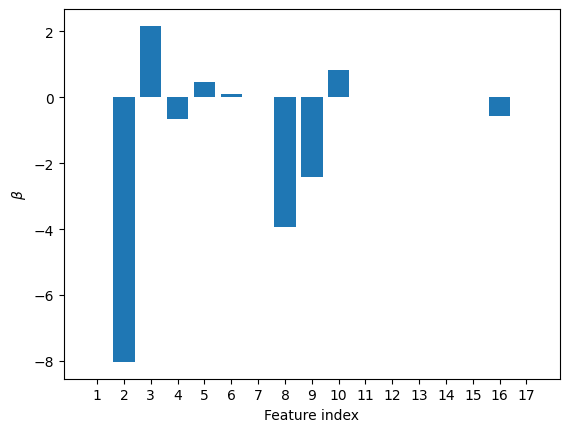

In [11]:
plt.bar(np.arange(len(feas)), np.squeeze(classifier.model.coef_))
plt.xticks(np.arange(len(feas)), np.arange(len(feas))+1)
plt.ylabel(r'$\beta$')
plt.xlabel('Feature index');

Finally the classifier can be applied on the observed features and the log-ratio for the observed features at `params` can be calculated based on the estimated class probabilities. That $\beta(i)=0$ for some features means that the features or summary statistics that contribute in the log-ratio estimate are selected automatically from the candidate set `feas`.

In [12]:
observed = np.array([m[node].observed for node in feas]).reshape(1, len(feas))
classifier.predict_log_likelihood_ratio(observed)

array([0.93283197])

The log-ratio estimates calculated in this manner can be converted into posterior probabilities and used to compare candidate parameter values as explanations for the observed data.
Question is then how to choose the candidate parameter values when we want to sample the approximate posterior distribution. 

### Log-ratio model

BOLFIRE uses Bayesian optimisation to choose the parameters used in log-ratio estimation. This means that the parameter values are chosen based on some acquisition method and a statistical model that captures dependencies between the log-ratio estimates and simulator parameters. The model is sequentially updated based on new information, and the fitted model is used to calculate an approximate posterior distribution over the simulator parameters.

`BOLFIRE` uses the same `GPyRegression` models as [BOLFI](https://elfi.readthedocs.io/en/latest/usage/BOLFI.html#fitting-the-surrogate-model).
Since our aim is to use the log-ratio model in posterior estimation, the model does not need to learn about parameter values that could not have produced the observed data, and we can use the prior distribution over parameter values to set the model bounds.

In [13]:
bounds = {'t1': (-1,1), 't2': (0,1)}

`BOLFIRE` can be initialised with a chosen `target_model` and `acquisition_method`, but here we let the method create a default model based on the bounds and also run optimisation with the default acquisition method. The model will first be initialised with `n_initial_evidence` log-ratios calculated at parameter values sampled from the prior distribution and then used in combination with the acquisition method to choose the next parameter values.

In [14]:
n_initial_evidence = 20

Now we can create a `BOLFIRE` instance for running parameter inference. `BOLFIRE` initialisation runs `nsim` simulations with parameter values sampled from the prior distribution to create a feature set to represent the marginal distribution in log-ratio estimation.

In [15]:
bolfire = elfi.BOLFIRE(
    model=m, 
    n_training_data=nsim, 
    feature_names=feas,
    classifier=classifier,
    bounds=bounds,
    n_initial_evidence=n_initial_evidence,
    seed=seed,
    seed_marginal=seed
)

We note that both `feature_names` and `classifier` are optional parameters. `feature_names` defaults to all summary nodes found in `model` and `classifier` defaults to `elfi.methods.classifier.LogisticRegression()`.

Let us run optimisation to fit the log-ratio model.

In [16]:
%time post = bolfire.fit(n_evidence=100, bar=False)

CPU times: user 1min 38s, sys: 5.7 s, total: 1min 44s
Wall time: 1min 31s


`fit` returns a `BOLFIREPosterior` instance that can be understood as an approximate posterior model calculated based on the fitted log-ratio model and the prior distribution over parameter values. Here we visualise the approximate posterior distribution and the acquisition locations that indicate which parameter values were used to run simulations and calculate log-ratio estimates.

In [17]:
resolution=100
X1, X2 = np.meshgrid(np.linspace(bounds['t1'][0], bounds['t1'][1], resolution), np.linspace(bounds['t2'][0], bounds['t2'][1], resolution))
xplot = np.column_stack([X1.ravel(), X2.ravel()])

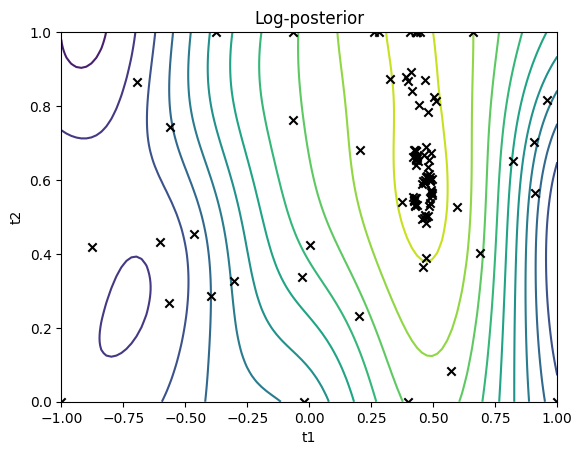

In [18]:
cset=plt.contour(X1, X2, post.logpdf(xplot).reshape((resolution, resolution)), levels=10)
plt.scatter(bolfire.target_model.X[:, 0], bolfire.target_model.X[:, 1], zorder=10, color='k', marker='x');
plt.xlim(bounds['t1'])
plt.ylim(bounds['t2'])
plt.xlabel('t1')
plt.ylabel('t2')
plt.title('Log-posterior');

We can also find the parameters that maximise the estimated posterior probability.

In [19]:
post.compute_map_estimates()

OrderedDict([('t1', 0.45948788396418994), ('t2', 0.5892862560048351)])

### Posterior sample

Finally we can sample the approximate posterior with an MCMC sampler.

In [20]:
%time result_BOLFIRE = bolfire.sample(2000)

CPU times: user 11min 33s, sys: 1min 13s, total: 12min 47s
Wall time: 8min 15s


We can summarise and visualise the inference results.

In [21]:
result_BOLFIRE

Method: BOLFIRE
Number of samples: 4000
Number of simulations: 50000
Parameter                Mean               2.5%              97.5%
t1:                     0.406             -0.010              0.695
t2:                     0.625              0.110              0.985


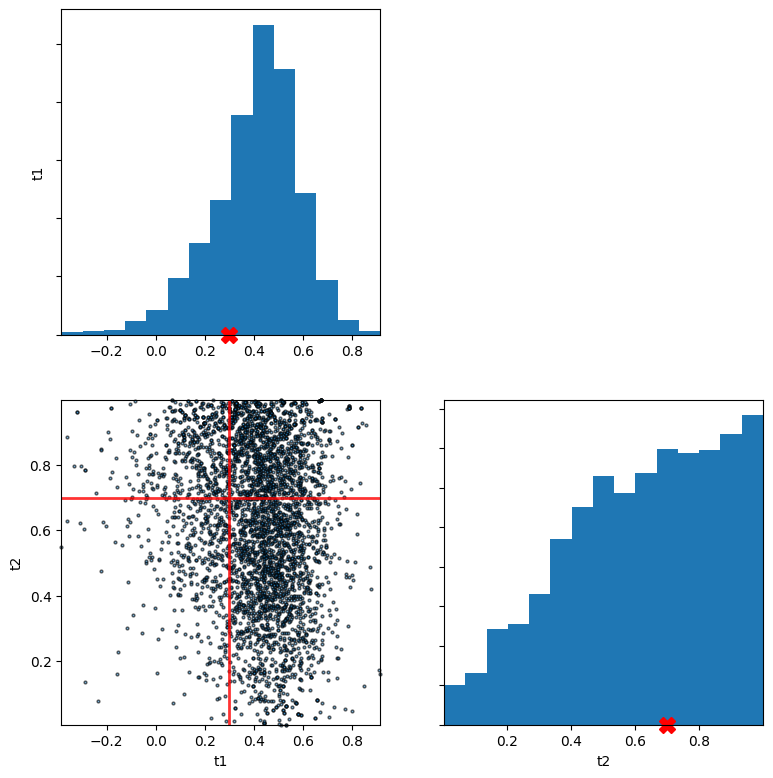

In [22]:
result_BOLFIRE.plot_pairs(reference_value={'t1': 0.3, 't2': 0.7}, bins=15);

### References

[1] Thomas O, Dutta R, Corander J, Kaski S, Gutmann MU. Likelihood-Free Inference by Ratio Estimation. Bayesian Analysis 17(1): 1-31, 2022. https://doi.org/10.1214/20-BA1238

[2] Kokko J. Bayesian Optimization and Classification in Likelihood-Free Inference. University of Helsinki, 2019. http://urn.fi/URN:NBN:fi:hulib-201908283357